# IMPORT LIBRARIES

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, TensorDataset, random_split
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, f1_score
import re
import nltk
import contractions
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import kagglehub
import os
from wordcloud import WordCloud, ImageColorGenerator
from collections import Counter
import matplotlib.pyplot as plt
from google.colab import drive
from PIL import Image
import seaborn as sns


nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('wordnet')

# specify GPU
device = torch.device("cuda")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


# Read data

In [4]:

path = kagglehub.dataset_download("nelgiriyewithana/mcdonalds-store-reviews")

print("Path to dataset files:", path)
print(os.listdir(path))


100%|██████████| 1.78M/1.78M [00:00<00:00, 153MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/nelgiriyewithana/mcdonalds-store-reviews/versions/1
['McDonald_s_Reviews.csv']


In [5]:

file_path= "/root/.cache/kagglehub/datasets/nelgiriyewithana/mcdonalds-store-reviews/versions/1/McDonald_s_Reviews.csv"
df=pd.read_csv(file_path,encoding="ISO-8859-1")
df.head()


,reviewer_id,store_name,category,store_address,latitude,longitude,rating_count,review_time,review,rating
0,1,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",3 months ago,Why does it look like someone spit on my food?...,1 star
1,2,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",5 days ago,It'd McDonalds. It is what it is as far as the...,4 stars
2,3,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",5 days ago,Made a mobile order got to the speaker and che...,1 star
3,4,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",a month ago,My mc. Crispy chicken sandwich was ï¿½ï¿½ï¿½ï¿...,5 stars
4,5,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",2 months ago,"I repeat my order 3 times in the drive thru, a...",1 star


**Label**

In [6]:
df['rating'] = df['rating'].replace({
    '1 star': 1,
    '2 stars': 2,
    '3 stars': 3,
    '4 stars': 4,
    '5 stars': 5
}).astype(int)
df.head()

<ipython-input-6-f6c8b0fc800e>:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['rating'] = df['rating'].replace({


,reviewer_id,store_name,category,store_address,latitude,longitude,rating_count,review_time,review,rating
0,1,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",3 months ago,Why does it look like someone spit on my food?...,1
1,2,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",5 days ago,It'd McDonalds. It is what it is as far as the...,4
2,3,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",5 days ago,Made a mobile order got to the speaker and che...,1
3,4,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",a month ago,My mc. Crispy chicken sandwich was ï¿½ï¿½ï¿½ï¿...,5
4,5,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",2 months ago,"I repeat my order 3 times in the drive thru, a...",1


# EDA

**Rating Count**

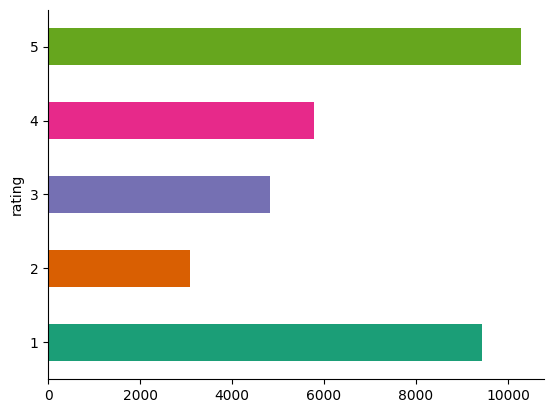

In [7]:
df.groupby('rating').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

# **Clean Text**

In [8]:
#boş yorumlar  ve eksik veriler silinir.
df['rating'] = df['rating'].astype(str).str.extract(r'(\d+)').astype(int)
df.dropna(subset=['review'], inplace=True)
df = df[df['review'].str.strip() != ""]

In [9]:
# Lemmatizer ve stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

In [10]:
def clean_text(text):
    text = contractions.fix(text) #kısa kelimeleri açar don't->do not
    text = text.lower()
    # özel karakterleri temizler
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    # birden fazla boşluğu tek bir boşlukla değiştirip baştaki ve sondaki boşlukları kaldırır
    text = re.sub(r'\s+', ' ', text).strip()
    words = word_tokenize(text) #cümleyi kelimelere ayırır
    # Stopwords ve noktalama işaretlerini çıkarır ve kelimeleri lemmatize eder
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words and word.isalpha()]
    return " ".join(words)

In [11]:
df['review'] = df['review'].apply(clean_text)

In [12]:
#etiketleme
df['label'] = df['rating'].map({1: 0, 2: 0, 3: 1, 4: 2, 5: 2})

**WordCloud**

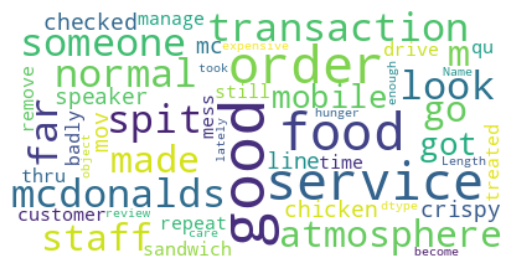

In [14]:
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(str(df['review']))
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


**term_frequency**

In [15]:
def term_frequency(text):
    words = text.split()
    word_counts = Counter(words)
    total_words = len(words)
    # Use a different variable name to avoid conflict with external 'tf'
    term_freq = {word: count / total_words for word, count in word_counts.items()}
    return term_freq


df['term_frequency'] = df['review'].apply(term_frequency)


In [16]:
print(df[['review', 'term_frequency']].head())

                                              review  \
0  look like someone spit food normal transaction...   
1  would mcdonalds far food atmosphere go staff m...   
2  made mobile order got speaker checked line mov...   
3  mc crispy chicken sandwich customer service qu...   
4  repeat order time drive thru still manage mess...   

                                      term_frequency  
0  {'look': 0.047619047619047616, 'like': 0.04761...  
1  {'would': 0.05, 'mcdonalds': 0.05, 'far': 0.05...  
2  {'made': 0.03125, 'mobile': 0.03125, 'order': ...  
3  {'mc': 0.125, 'crispy': 0.125, 'chicken': 0.12...  
4  {'repeat': 0.03225806451612903, 'order': 0.064...  


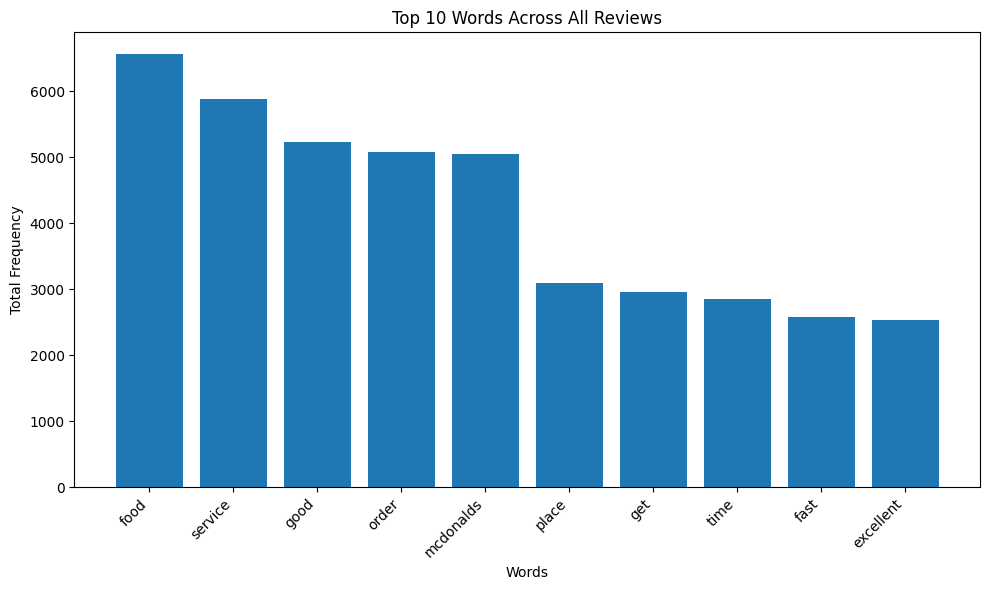

In [17]:
all_words = []
for tf in df['term_frequency']:
    all_words.extend(list(tf.keys()))

word_counts = Counter(all_words)
top_words_all = dict(sorted(word_counts.items(), key=lambda item: item[1], reverse=True)[:10])

plt.figure(figsize=(10, 6))
plt.bar(top_words_all.keys(), top_words_all.values())
plt.xlabel("Words")
plt.ylabel("Total Frequency")
plt.title("Top 10 Words Across All Reviews")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# BertTokenizer

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def encode_texts(texts, tokenizer, max_length=256): #metinleri BERT'in anlayacağı formata çevirir
    encodings = tokenizer.batch_encode_plus(
        texts.tolist(), #listeye çevirir
        max_length=max_length,
        truncation=True, #max aşılırsa keser
        padding='max_length', #doldurma
        return_tensors='pt'
    )
    return encodings #input_ids ve attention_mask döndürülür


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
encodings = encode_texts(df['review'], tokenizer)
labels = torch.tensor(df['label'].values)

**TensorDataset**

In [ ]:
#bert için gerekli 3 bileşeni oluşturur
dataset = TensorDataset(encodings['input_ids'], encodings['attention_mask'], labels)


**Train-Test**

In [ ]:
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

**DataLoader**

In [ ]:
#veri batch olarak modele aktarılır . parça para
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# **SentimentModel**

In [ ]:
#Model oluşturma
class SentimentModel(nn.Module):
    def __init__(self, num_labels=3):
        super(SentimentModel, self).__init__()
        self.bert = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_labels)

    def forward(self, input_ids, attention_mask):
        return self.bert(input_ids, attention_mask=attention_mask).logits

In [ ]:
model = SentimentModel().to(device)
optimizer = optim.AdamW(model.parameters(), lr=2e-5) #model ağırlıkları optimize edklir
criterion = nn.CrossEntropyLoss()#kayıp fonk

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


**Train Model**

In [ ]:
# Model eğitimi
#her batch için loss ve accuarcu hesaplar
def train(model, train_loader, val_loader, optimizer, criterion, epochs=3):
    for epoch in range(epochs):
        model.train() #model eğitim modunda (katmanların yanlış çalışmasını engeller)
        total_loss, total_correct, train_preds, train_labels = 0, 0, [], []
        for batch in train_loader:
            input_ids, attention_mask, labels = [x.to(device) for x in batch]
            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)#crossentropy
            loss.backward() #kayıp fonk elen gradyanları hesaplar
            optimizer.step()
            total_loss += loss.item()
            total_correct += (outputs.argmax(dim=1) == labels).sum().item()

            # Eğitimdeki tahminleri toplama
            train_preds.extend(outputs.argmax(dim=1).cpu().numpy())
            train_labels.extend(labels.cpu().numpy())

        # Eğitim doğruluğu ve F1 skoru hesaplama
        train_acc = accuracy_score(train_labels, train_preds)
        train_f1 = f1_score(train_labels, train_preds, average='weighted')

        # Doğrulama doğruluğu ve F1 skoru hesaplama
        val_acc, val_f1 = evaluate(model, val_loader)

        print(f"Epoch {epoch + 1}: Loss: {total_loss / len(train_loader):.4f}, "
              f"Train Accuracy: {train_acc:.4f}, Train F1: {train_f1:.4f}, "
              f"Val Accuracy: {val_acc:.4f}, Val F1: {val_f1:.4f}")

**Eval Model**

In [ ]:
# Modeli değerlendirme
def evaluate(model, val_loader):
    model.eval()
    true_vals, predictions = [], [] #gerçek etiket ve model tahmini
    with torch.no_grad():
        for batch in val_loader:
            input_ids, attention_mask, labels = [x.to(device) for x in batch]
            logits = model(input_ids, attention_mask)#model çıktılarını hesaplar
            preds = logits.argmax(dim=1).cpu().numpy() #model tahminleri alınır
            predictions.extend(preds)
            true_vals.extend(labels.cpu().numpy())

    # Accuracy ve F1 skorunu hesapla
    val_acc = accuracy_score(true_vals, predictions)
    val_f1 = f1_score(true_vals, predictions, average='weighted')
    return val_acc, val_f1

In [ ]:
# Modeli eğit
train(model, train_loader, val_loader, optimizer, criterion, epochs=3)


Epoch 1: Loss: 0.5167, Train Accuracy: 0.8035, Train F1: 0.7827, Val Accuracy: 0.8183, Val F1: 0.8072
Epoch 2: Loss: 0.4031, Train Accuracy: 0.8469, Train F1: 0.8367, Val Accuracy: 0.8286, Val F1: 0.8177
Epoch 3: Loss: 0.3063, Train Accuracy: 0.8862, Train F1: 0.8824, Val Accuracy: 0.8329, Val F1: 0.8307


**Save Model**

In [ ]:
drive.mount('/content/drive')
torch.save(model.state_dict(), '/content/drive/My Drive/bert_model2.pt')

Mounted at /content/drive
